<a href="https://colab.research.google.com/github/JackNguyen1209/UIT_AITempoRun-/blob/main/(Ban_Chinh)AI_tempo_run_Full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Khai báo sử dụng thư viện

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as ex
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
pyo.init_notebook_mode()
from imblearn.over_sampling import SMOTE

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score


from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import os

from sklearn.metrics import classification_report,confusion_matrix,f1_score
import warnings
warnings.filterwarnings('ignore')

plt.rc('figure',figsize=(17,13))
sns.set_context('paper',font_scale=2)

def set_seed(seed=31415):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



#**Tiền xử lý dữ liệu**

##Đọc dữ liệu từ file train.csv

In [ ]:
data = pd.read_csv('/content/train.csv')
data.head()

id  gender   age  hypertension  ...  smoking_status blood height stroke
0   77  Female   NaN           0.0  ...         Unknown     O    NaN      0
1   84    Male  55.0           0.0  ...    never smoked     B   1.59      0
2   91  Female  42.0           0.0  ...    never smoked     B    NaN      0
3   99  Female  31.0           0.0  ...         Unknown     O   1.24      0
4  121  Female  38.0           0.0  ...         Unknown     O    NaN      0

[5 rows x 14 columns]

###*Nhận xét:*
Có nhiều điểm dữ liệu có thành phần bị trống. Vì vậy chúng ta sẽ liệt kê các thành phần của điểm dữ liệu trống và xây dựng ma trận tương quan (matrix_cor)

In [ ]:
plt.figure(figsize=(10, 10))
plt.title('Các giá trị trống',fontweight='bold')
ax = sns.heatmap(data.isna().sum().to_frame(),annot=True,fmt='d',cmap='inferno')
ax.set_xlabel('số lượng')
plt.show()

In [ ]:
plt.figure(figsize=(14, 14))
cor_matrix = data.corr()
sns.heatmap(cor_matrix, annot=True)
plt.show()

Ta nhận thấy rằng trong chỉ số bmi sẽ phụ thuộc nhiều vào chiều cao và không nhiều lắm ở tuổi. Cho nên chúng ta sẽ xây dựng model để predict giá trị BMI phụ thuộc vào chiều cao và tuổi. 
Tuổi có missing value là 107, do đó chúng ta sẽ thực hiện random giá trị

#**Hàm xử lí bộ dữ liệu**

In [ ]:
datatest=pd.read_csv('/content/public_test.csv')
datatest.head()

id  gender   age  hypertension  ...   bmi   smoking_status blood height
0   67  Female  17.0           0.0  ...   NaN  formerly smoked    AB    NaN
1  210    Male  81.0           0.0  ...  31.4     never smoked     A   1.60
2  242    Male   4.0           NaN  ...  17.5          Unknown     O    NaN
3  711    Male  81.0           0.0  ...  22.2     never smoked    AB    NaN
4  724    Male  17.0           0.0  ...  44.7     never smoked     O   1.34

[5 rows x 13 columns]

Dùng model được train từ dữ liệu trong tập train, từ đó dùng để fill các missing value trong tập train và tập test

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

def XuLiBoDuLieu(dataset_train, dataset_test):

  #bmi: height (svr)
  dataset_train['height']=dataset_train['height'].fillna(np.mean(dataset_train['height']))
  dataset_test['height']=dataset_test['height'].fillna(np.mean(dataset_test['height']))
  from sklearn.svm import SVR
  svr=SVR(kernel="rbf")
  #dataset = dataset['bmi'].dropna(axis=0, how=any)
  X = dataset_train[['height','bmi']].copy()
  Missing = X[X['bmi'].isna()]
  X = X[~X['bmi'].isna()]
  Y = X.pop('bmi')
  svr.fit(X,Y)
  predicted_bmi = pd.Series(svr.predict(Missing[['height']]),index=Missing.index)
  dataset_train.loc[Missing.index,'bmi'] = predicted_bmi

  X = dataset_test[['height','bmi']].copy()
  Missing = X[X['bmi'].isna()]
  predicted_bmi = pd.Series(svr.predict(Missing[['height']]),index=Missing.index)
  dataset_test.loc[Missing.index,'bmi'] = predicted_bmi

  #tuổi(2) : worktype(6), ever-mary(5) bmi(9) (thử model)
  print('Tuổi(2) : worktype(6), ever-mary(5) bmi(9) (thử model)')
  ## Xử lí trên tập train
  DT_bmi_pipe = Pipeline( steps=[('scale',StandardScaler()),('lr',SVR(kernel="rbf"))])
  ohe=ColumnTransformer([('one_hot_encoder', OneHotEncoder(categories='auto'), [5,6])], remainder='passthrough')
  X_ohe=ohe.fit_transform(dataset_train)
  df_X_ohe = pd.DataFrame(X_ohe)
  df_X_ohe.head()
  X = df_X_ohe[[0, 1, 2,3,4,5,6, 14,9]].copy()
  Missing = X[X[9].isna()]
  X = X[~X[9].isna()]
  Y = X.pop(9)
  DT_bmi_pipe.fit(X,Y)
  predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[[0, 1, 2,3,4,5,6, 14]]),index=Missing.index)
  dataset_train.loc[Missing.index,'age'] = predicted_bmi
  ###Xử lí trên tập test
  ohe=ColumnTransformer([('one_hot_encoder', OneHotEncoder(categories='auto'), [5,6])], remainder='passthrough')
  X_ohe=ohe.fit_transform(dataset_test)
  df_X_ohe = pd.DataFrame(X_ohe)
  df_X_ohe.head()
  X = df_X_ohe[[0, 1, 2,3,4,5,6,14, 9]].copy()
  Missing = X[X[9].isna()]
  predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[[0, 1, 2,3,4,5,6,14]]),index=Missing.index)
  dataset_test.loc[Missing.index,'age'] = predicted_bmi

  #Lượng đường(8): Tuổi(2), bmi(9)
  print('Lượng đường(8): Tuổi(2) bmi(9)')
  ##Xử lí trên tập train
  DT_bmi_pipe = Pipeline( steps=[('scale',StandardScaler()),('lr',SVR(kernel="rbf"))])
  X = dataset_train[['age','bmi','avg_glucose_level']].copy()
  Missing = X[X['avg_glucose_level'].isna()]
  X = X[~X['avg_glucose_level'].isna()]
  Y = X.pop('avg_glucose_level')
  DT_bmi_pipe.fit(X,Y)
  predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age','bmi']]),index=Missing.index)
  dataset_train.loc[Missing.index,'avg_glucose_level'] = predicted_bmi
  ##Xử lí trên tập test
  X = dataset_test[['age','bmi','avg_glucose_level']].copy()
  Missing = X[X['avg_glucose_level'].isna()]
  predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age','bmi']]),index=Missing.index)
  dataset_test.loc[Missing.index,'avg_glucose_level'] = predicted_bmi

  #Heart Disease(4) : tuổi(2)
  print('Heart Disease(4) : tuổi(2)')
  ##Xử lí trên tập train
  DT_bmi_pipe = Pipeline( steps=[('scale',StandardScaler()),('lr',SVC(kernel='rbf'))])
  X = dataset_train[['age','heart_disease']].copy()
  Missing = X[X['heart_disease'].isna()]
  X = X[~X['heart_disease'].isna()]
  Y = X.pop('heart_disease')
  DT_bmi_pipe.fit(X,Y)
  predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age']]),index=Missing.index)
  dataset_train.loc[Missing.index,'heart_disease'] = predicted_bmi
  ##Xử lí trên tập test
  X = dataset_test[['age','heart_disease']].copy()
  Missing = X[X['heart_disease'].isna()]
  predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age']]),index=Missing.index)
  dataset_test.loc[Missing.index,'heart_disease'] = predicted_bmi

XuLiBoDuLieu(data,datatest)

Tuổi(2) : worktype(6), ever-mary(5) bmi(9) (thử model)
Lượng đường(8): Tuổi(2) bmi(9)
Heart Disease(4) : tuổi(2)


In [ ]:
data.head()

id  gender        age  hypertension  ...  smoking_status blood    height stroke
0   77  Female   5.871549           0.0  ...         Unknown     O  1.611831      0
1   84    Male  55.000000           0.0  ...    never smoked     B  1.590000      0
2   91  Female  42.000000           0.0  ...    never smoked     B  1.611831      0
3   99  Female  31.000000           0.0  ...         Unknown     O  1.240000      0
4  121  Female  38.000000           0.0  ...         Unknown     O  1.611831      0

[5 rows x 14 columns]

In [ ]:
datatest.head()

id  gender   age  hypertension  ...        bmi   smoking_status blood    height
0   67  Female  17.0           0.0  ...  24.177084  formerly smoked    AB  1.620718
1  210    Male  81.0           0.0  ...  31.400000     never smoked     A  1.600000
2  242    Male   4.0           NaN  ...  17.500000          Unknown     O  1.620718
3  711    Male  81.0           0.0  ...  22.200000     never smoked    AB  1.620718
4  724    Male  17.0           0.0  ...  44.700000     never smoked     O  1.340000

[5 rows x 13 columns]

In [ ]:
plt.figure(figsize=(10, 10))
plt.title('Các giá trị trống',fontweight='bold')
ax = sns.heatmap(data.isna().sum().to_frame(),annot=True,fmt='d',cmap='inferno')
ax.set_xlabel('số lượng')
plt.show()

Lưu kết quả xuống file csv train_modified

Kết thúc bước tiền xử lí dữ liệu

In [ ]:
filename='train_modified_decisiontree.csv'
re=np.array(data)
kq=pd.DataFrame(data)
kq.to_csv(filename,index=False)

filename='test_modified_decisiontree.csv'
re=np.array(datatest)
kq=pd.DataFrame(datatest)
kq.to_csv(filename,index=False)

#**Xây dựng model tập train_modified**

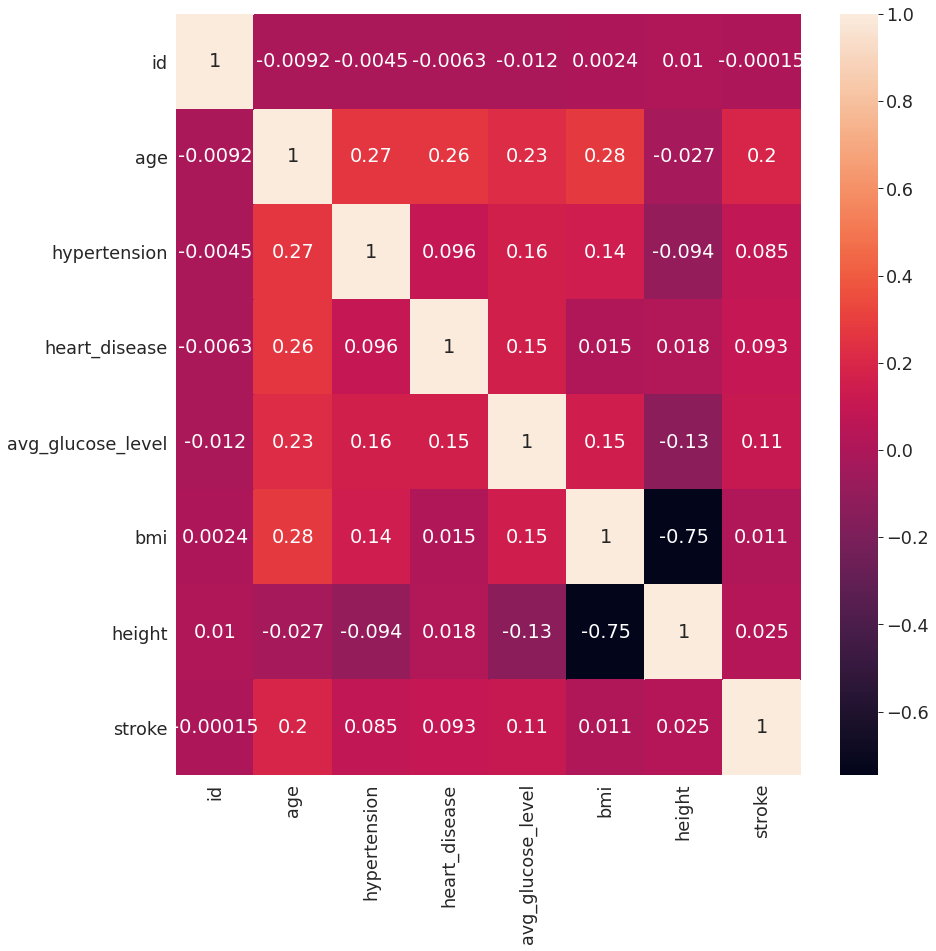

In [ ]:
datatrain=pd.read_csv('/content/train_modified_decisiontree.csv')
plt.figure(figsize=(14, 14))
cor_matrix = data.corr()
sns.heatmap(cor_matrix, annot=True)
plt.show()

In [ ]:
datatrain.pop('id')
datatrain.pop('blood')
datatrain.pop('hypertension')
datatrain.head()

gender        age  heart_disease  ... smoking_status    height stroke
0  Female   5.871549            0.0  ...        Unknown  1.611831      0
1    Male  55.000000            0.0  ...   never smoked  1.590000      0
2  Female  42.000000            0.0  ...   never smoked  1.611831      0
3  Female  31.000000            0.0  ...        Unknown  1.240000      0
4  Female  38.000000            0.0  ...        Unknown  1.611831      0

[5 rows x 11 columns]

Bởi vì số lượng điểm dữ liệu khẳng định với việc bị đột quị $<<$ số lượng điểm dữ liệu phủ định với việc bị đột quị nên chúng ta sử dụng phương pháp SMOTE để upsampling dữ liệu để giúp việc training model được tốt hơn

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

ohe=ColumnTransformer([('one_hot_encoder', OneHotEncoder(categories='auto'), [0,3,4,5,8])], remainder='passthrough')
X_ohe=ohe.fit_transform(datatrain)

df_X_ohe = pd.DataFrame(X_ohe)
df_X_ohe.head()


0    1    2    3    4   ...   18      19         20        21   22
0  1.0  0.0  0.0  1.0  0.0  ...  0.0   85.81  18.600000  1.611831  0.0
1  0.0  1.0  0.0  0.0  1.0  ...  0.0   89.17  25.686215  1.590000  0.0
2  1.0  0.0  0.0  1.0  0.0  ...  0.0   98.53  18.500000  1.611831  0.0
3  1.0  0.0  0.0  1.0  0.0  ...  0.0  108.89  52.300000  1.240000  0.0
4  1.0  0.0  0.0  0.0  1.0  ...  0.0   91.44  24.328188  1.611831  0.0

[5 rows x 23 columns]

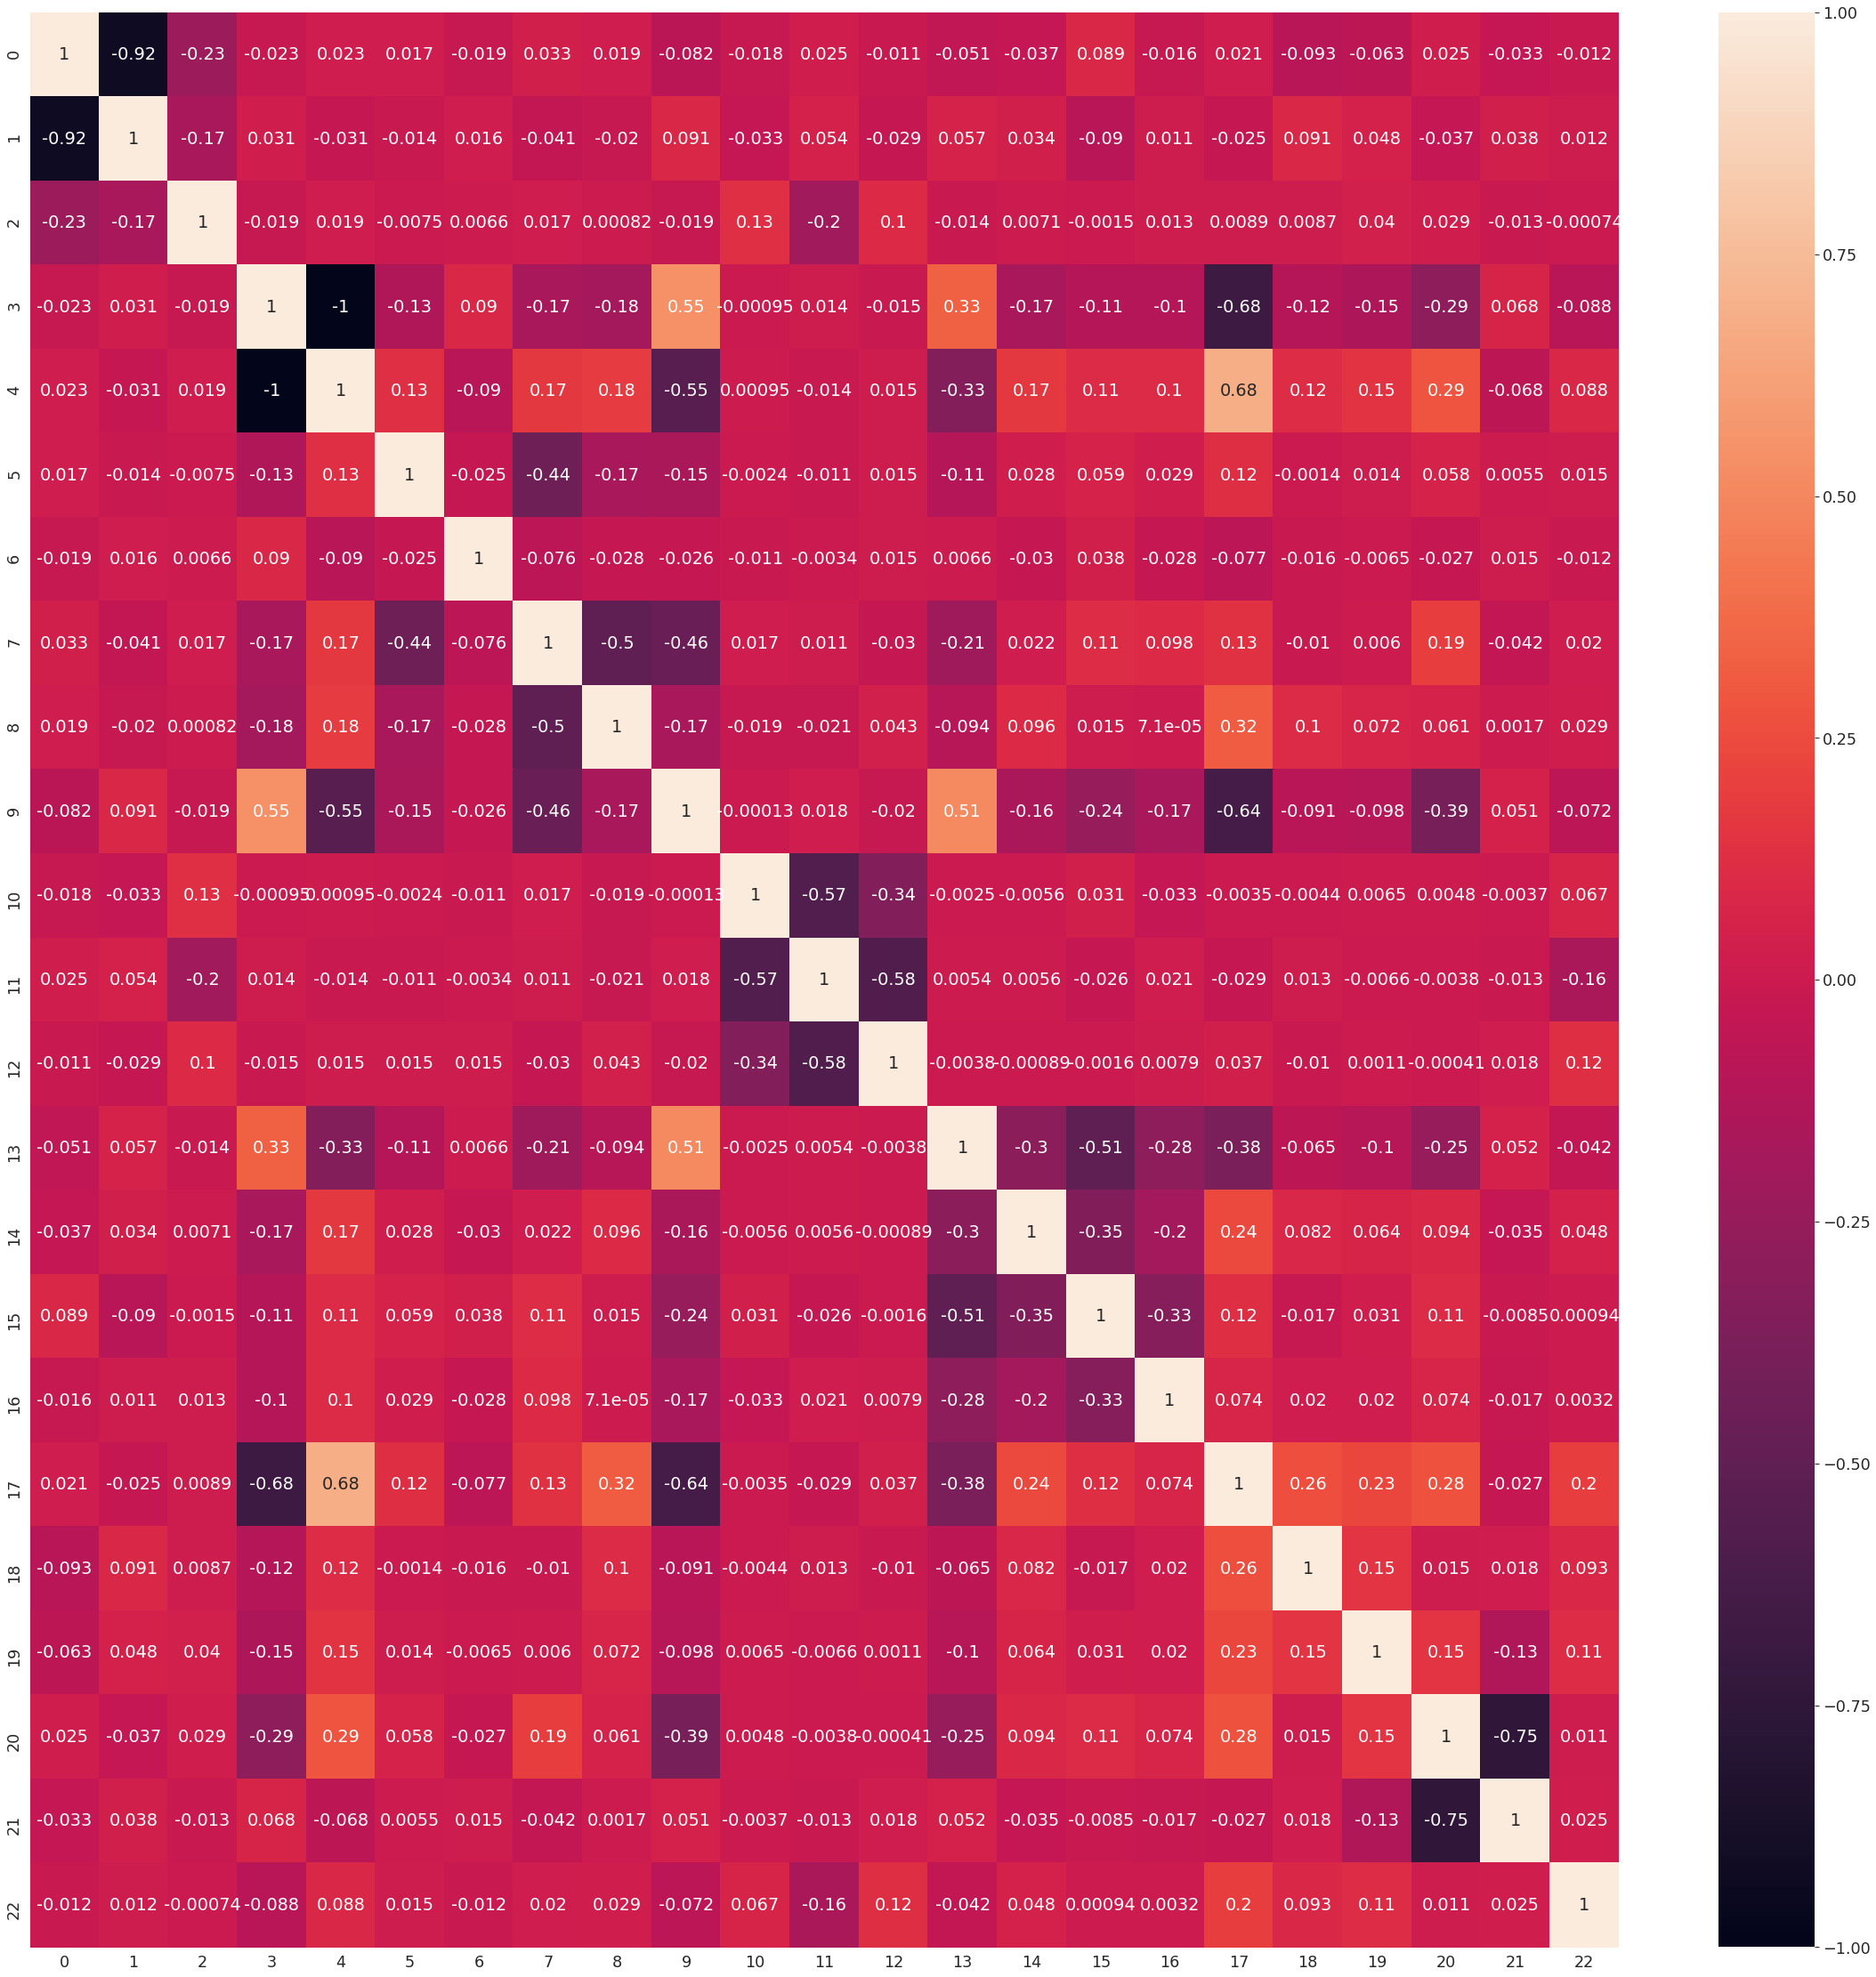

In [ ]:
plt.figure(figsize=(40, 40))
cor_matrix = df_X_ohe.corr()
sns.heatmap(cor_matrix, annot=True)
plt.show()

Chon 1 trong cac cai sau:

In [ ]:
X_Train_sm=df_X_ohe.iloc[:,[17,18,19]]
Y_Train_sm=df_X_ohe.iloc[:,22:23]

In [ ]:
from imblearn.combine import SMOTEENN
enn=SMOTEENN(random_state=0)
X_Train=df_X_ohe.iloc[:,0:22]
Y_Train=df_X_ohe.iloc[:,22:23]
X_Train_sm,Y_Train_sm=enn.fit_resample(df_X_ohe.iloc[:,[12,17,19]], df_X_ohe.iloc[:,22:23])
#X_Train_sm=X_Train_sm[:,[17,18,19]]

In [ ]:
from imblearn.combine import SMOTETomek
enn=SMOTETomek(random_state=0)
X_Train=df_X_ohe.iloc[:,0:22]
Y_Train=df_X_ohe.iloc[:,22:23]
X_Train_sm,Y_Train_sm=enn.fit_resample(X_Train, Y_Train)
X_Train_sm=X_Train_sm[:,[17,18,19]]

In [ ]:
oversample = SMOTE()
X_Train=df_X_ohe.iloc[:,0:22]
Y_Train=df_X_ohe.iloc[:,22:23]
X_Train_sm,Y_Train_sm=oversample.fit_resample(X_Train, Y_Train)
X_Train_sm=X_Train_sm[:,[17,18,19]]

In [ ]:
DT_PIPE = Pipeline(steps = [('scale',StandardScaler()),('DT',DecisionTreeClassifier(random_state=42))])
RF_PIPE = Pipeline(steps = [('scale',StandardScaler()),('DT',RandomForestClassifier(random_state=42))])
SVM_PIPE = Pipeline(steps = [('scale',StandardScaler()),('DT',SVC(random_state=42))])
LR_PIPE = Pipeline(steps = [('scale',StandardScaler()),('DT',LogisticRegression(random_state=42))])
KN_PIPE = Pipeline(steps = [('scale',StandardScaler()),('DT',KNeighborsClassifier(n_neighbors=1))])

Train trên dữ liệu trên tập đã sampling

In [ ]:
DT_PIPE.fit(X_Train_sm,Y_Train_sm)
RF_PIPE.fit(X_Train_sm,Y_Train_sm)
SVM_PIPE.fit(X_Train_sm,Y_Train_sm)
LR_PIPE.fit(X_Train_sm,Y_Train_sm)
KN_PIPE.fit(X_Train_sm,Y_Train_sm)

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('DT',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=1, p=2,
                                      weights='uniform'))],
         verbose=False)

#**Đọc và xử lí dữ liệu trên bộ test**

Xử lí dữ liệu Nan trên tập test

In [ ]:
datatest=pd.read_csv('/content/test_modified_decisiontree.csv')
datatest.head()

id  gender   age  hypertension  ...        bmi   smoking_status blood    height
0   67  Female  17.0           0.0  ...  24.177084  formerly smoked    AB  1.620718
1  210    Male  81.0           0.0  ...  31.400000     never smoked     A  1.600000
2  242    Male   4.0           NaN  ...  17.500000          Unknown     O  1.620718
3  711    Male  81.0           0.0  ...  22.200000     never smoked    AB  1.620718
4  724    Male  17.0           0.0  ...  44.700000     never smoked     O  1.340000

[5 rows x 13 columns]

In [ ]:
datatest.pop('id')
datatest.pop('blood')
datatest.pop('hypertension')
datatest.head()

gender   age  heart_disease  ...        bmi   smoking_status    height
0  Female  17.0            0.0  ...  24.177084  formerly smoked  1.620718
1    Male  81.0            0.0  ...  31.400000     never smoked  1.600000
2    Male   4.0            0.0  ...  17.500000          Unknown  1.620718
3    Male  81.0            0.0  ...  22.200000     never smoked  1.620718
4    Male  17.0            0.0  ...  44.700000     never smoked  1.340000

[5 rows x 10 columns]

In [ ]:
ohe=ColumnTransformer([('one_hot_encoder', OneHotEncoder(categories='auto'), [0,3,4,5,8])], remainder='passthrough')
X_ohe=ohe.fit_transform(datatest)
df_X_ohe = pd.DataFrame(X_ohe)
df_X_ohe.head()

0    1    2    3    4    5   ...   16    17   18     19         20        21
0  1.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  17.0  0.0  92.97  24.177084  1.620718
1  0.0  1.0  0.0  0.0  1.0  0.0  ...  0.0  81.0  0.0  91.54  31.400000  1.600000
2  0.0  1.0  0.0  1.0  0.0  0.0  ...  0.0   4.0  0.0  98.56  17.500000  1.620718
3  0.0  1.0  0.0  0.0  1.0  0.0  ...  0.0  81.0  0.0  92.96  22.200000  1.620718
4  0.0  1.0  0.0  1.0  0.0  0.0  ...  0.0  17.0  0.0  81.77  44.700000  1.340000

[5 rows x 22 columns]

In [ ]:
X_Test=df_X_ohe.iloc[:,[12,17,19]]

# **Đánh giá mô hình**

Đọc file kết quả chính:

In [ ]:
dataresult=pd.read_csv('/content/ans.csv')
Y_Test=dataresult.iloc[:500,1]

In [ ]:
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
bb=BalancedBaggingClassifier(random_state=0, n_jobs=3)
bb.fit(X_Train_sm,Y_Train_sm)
print(f1_score(Y_Test,bb.predict(X_Test)))

bbsvc=BalancedBaggingClassifier(base_estimator=SVC(),n_estimators=50,random_state=0, n_jobs=3)
#bbsvc.fit(X_Train_sm,Y_Train_sm)
#print(f1_score(Y_Test,bbsvc.predict(X_Test)))

bbsvc=RUSBoostClassifier(n_estimators=200,algorithm='SAMME.R',random_state=0)
bbsvc.fit(X_Train_sm,Y_Train_sm)
print(f1_score(Y_Test,bbsvc.predict(X_Test)))

0.2727272727272727
0.3053435114503817


In [ ]:
DT_PRED   = DT_PIPE.predict(X_Test)
RF_PRED   = RF_PIPE.predict(X_Test)
SV_PRED   = SVM_PIPE.predict(X_Test)
LR_PRED   = LR_PIPE.predict(X_Test)
KN_PRED   = KN_PIPE.predict(X_Test)

RF_F1  = f1_score(Y_Test,RF_PRED )
DT_F1  = f1_score(Y_Test,DT_PRED )
SV_F1  = f1_score(Y_Test,SV_PRED )
LR_F1  = f1_score(Y_Test,LR_PRED )
KN_F1  = f1_score(Y_Test,KN_PRED )

print(DT_F1)
print(RF_F1)
print(SV_F1)
print(LR_F1)
print(KN_F1)

from sklearn.metrics import accuracy_score
print(accuracy_score(Y_Test,RF_PRED ))
print(accuracy_score(Y_Test,DT_PRED ))
print(accuracy_score(Y_Test,SV_PRED ))
print(accuracy_score(Y_Test,LR_PRED ))
print(accuracy_score(Y_Test,KN_PRED ))

print(confusion_matrix(Y_Test,LR_PRED))

0.2773722627737226
0.28346456692913385
0.32487309644670054
0.29357798165137616
0.2748091603053435
0.818
0.802
0.734
0.692
0.81
[[314 146]
 [  8  32]]


#**Xuất file csv**

In [ ]:
datatest=pd.read_csv('/content/public_test.csv')
filename='submission.csv'
col_id=datatest.iloc[:,0]


def tao_ans(id,y_pred):
  ans=[]
  a=['id']
  b=['stroke']
  ans.append(a)
  ans.append(b)
  for i in range (0, len(id)):
    ans[0].append(id[i])
  for i in range (0, len(id)):
    ans[1].append(y_pred[i])
  ans2=[]
  for i in range(0,len(ans[0])):
    x=[]
    x.append(ans[0][i])
    x.append(ans[1][i])
    ans2.append(x)

  filename='submission.csv'
  re=np.array(ans2)
  kq=pd.DataFrame(ans2)
  kq.to_csv(filename,index=False)
tao_ans(col_id,LR_PRED)